In [242]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import os
import missingno as msno
import shapely.io
from shapely.geometry import Point, LineString

from lxml import etree
from datetime import time

# Load GTFS data

https://github.com/matsim-org/matsim-libs/tree/master/examples/scenarios/pt-tutorial

## Shapes = edges

In [243]:
shapes_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/shapes.txt'

shapes = pd.read_csv(shapes_filename)
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,SHP_185_I,39.484123,-0.391542,0,0.0
1,SHP_185_I,39.485841,-0.390737,1,203.0
2,SHP_185_I,39.485841,-0.390737,2,203.0
3,SHP_185_I,39.487875,-0.389816,3,442.0
4,SHP_185_I,39.487875,-0.389816,4,442.0
...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0


In [244]:
shapes['geometry'] = shapes.apply(lambda row: Point(row['shape_pt_lon'], row['shape_pt_lat']), axis='columns')
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996)
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057)
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057)
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054)
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054)
...,...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409)
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539)
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (-0.413271655644534 39.46973086759)
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0,POINT (-0.413919991912794 39.4696883517495)


In [245]:
edges = shapes.groupby('shape_id')['geometry'].apply(lambda x: LineString(x.to_list()))
edges = gpd.GeoDataFrame(edges, geometry='geometry')
edges = edges.set_crs('EPSG:4326')
edges

,geometry
shape_id,
SHP_1007_I,"LINESTRING (-0.41719 39.4684, -0.41737 39.4684..."
SHP_1007_V,"LINESTRING (-0.3457 39.47925, -0.34615 39.4782..."
SHP_1017_I,"LINESTRING (-0.3763 39.47061, -0.37613 39.4703..."
SHP_1017_V,"LINESTRING (-0.33179 39.44742, -0.33195 39.447..."
SHP_1018_I,"LINESTRING (-0.37837 39.46796, -0.3785 39.468,..."
...,...
SHP_995_V,"LINESTRING (-0.40417 39.49014, -0.40409 39.490..."
SHP_996_I,"LINESTRING (-0.38776 39.48015, -0.38804 39.480..."
SHP_996_V,"LINESTRING (-0.35594 39.47516, -0.35588 39.475..."


<Axes: >

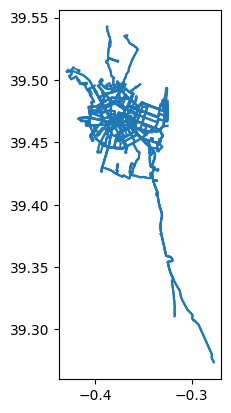

In [246]:
edges.plot()

In [247]:
if not os.path.exists('data/redes/bus/emt_shp/'):
    os.mkdir('data/redes/bus/emt_shp/')

edges.to_file('data/redes/bus/emt_shp/emt_edges.shp', driver='ESRI Shapefile')

## Stops

In [248]:
stops_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/stops.txt'

stops = pd.read_csv(stops_filename)
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,10,10,Doctor Lluch - Mediterrània,C DOCTOR LLUCH 99 (DAVANT) - VALÈNCIA,39.467234,-0.328306,NaN,NaN,0,NaN
1,1007,1007,Jesús Morante Borrás (I),AV JESUS MORANTE BORRAS 26 - VALÈNCIA,39.451015,-0.345435,NaN,NaN,0,NaN
2,1008,1008,Jesús Morante Borrás (II),AV JESUS MORANTE BORRAS 54 - VALÈNCIA,39.449483,-0.344468,NaN,NaN,0,NaN
3,1009,1009,Jesús Morante Borrás (III),AV JESUS MORANTE BORRAS 86 - VALÈNCIA,39.447905,-0.344029,NaN,NaN,0,NaN
4,1010,1010,Jesús Morante Borrás (IV),AV JESUS MORANTE BORRAS 158 - VALÈNCIA,39.444148,-0.343987,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
1141,978,978,Carters (parell) - Primer de Maig,C CARTEROS 84 - VALÈNCIA,39.448198,-0.389623,NaN,NaN,0,NaN
1142,979,979,Carters - Mossén Febrer,C CARTEROS 60 (DAVANT) - VALÈNCIA,39.450171,-0.388974,NaN,NaN,0,NaN
1143,983,983,Ramón y Cajal - Bailén,GV RAMON Y CAJAL 1 - VALÈNCIA,39.463089,-0.379623,NaN,NaN,0,NaN
1144,985,985,Centre de Salut Benimaclet,C JAIME ESTEVE CUBELLS 6 - VALÈNCIA,39.483322,-0.358504,NaN,NaN,0,NaN


In [249]:
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis='columns')

<Axes: >

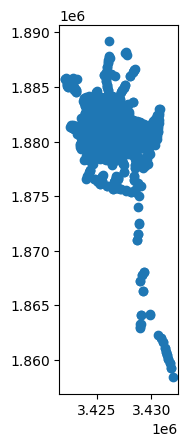

In [250]:
stops = gpd.GeoDataFrame(stops, geometry='geometry', crs='EPSG:4326')
stops = stops.to_crs('EPSG:3035')
stops.plot()

In [251]:
# if not os.path.exists('data/redes/bus/emt_shp/'):
#     os.mkdir('data/redes/bus/emt_shp/')
# 
# stops.to_file('data/redes/bus/emt_shp/emt_nodes.shp', driver='ESRI Shapefile')

## Routes

In [252]:
routes_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/routes.txt'

routes = pd.read_csv(routes_filename)
routes

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,23,EMT,23,POBLES DEL SUD,NaN,3,NaN,FE0000,FFFFFF
1,24,EMT,24,PORTA DE LA MAR - EL SALER / EL PALMAR,NaN,3,NaN,FE0000,FFFFFF
2,5,EMT,C1,CENTRE HISTÒRIC,NaN,3,NaN,FE0000,FFFFFF
3,63,EMT,63,CAMPUS DE BURJASSOT - ESTACIÓ DEL NORD,NaN,3,NaN,FE0000,FFFFFF
4,28,EMT,28,CIUTAT ART. FALLER - ESTACIÓ DEL NORD,NaN,3,NaN,FE0000,FFFFFF
5,95,EMT,95,JARDÍ DEL TÚRIA,NaN,3,NaN,FE0000,FFFFFF
6,4,EMT,4,PORT/NATZARET - POETA QUEROL,NaN,3,NaN,FE0000,FFFFFF
7,6,EMT,6,TORREFIEL - HOSPITAL LA FE,NaN,3,NaN,FE0000,FFFFFF
8,7,EMT,7,MERCAT CENTRAL - FTA. SANT LLUÍS,NaN,3,NaN,FE0000,FFFFFF
9,8,EMT,8,PORTA DE LA MAR - HOSPITAL LA FE,NaN,3,NaN,FE0000,FFFFFF


## Trips

In [253]:
trips_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/trips.txt'

trips = pd.read_csv(trips_filename)
trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,23,FES,1033D2V0,Porta de la Mar,0,10332,SHP_1033_V
1,23,FES,1033D2V1,Forn d'Alcedo,0,10332,SHP_1033_I
2,23,FES,1033D2V2,Porta de la Mar,0,10332,SHP_1033_V
3,23,FES,1033D2V3,Forn d'Alcedo,0,10332,SHP_1033_I
4,23,FES,1033D2V4,Porta de la Mar,0,10332,SHP_1033_V
...,...,...,...,...,...,...,...
2365,93,FES,994D2V,Av. del Cid,0,9942,SHP_994_V
2366,93,LAB,994D0I,Passeig Maritim,0,9940,SHP_994_I
2367,93,LAB,994D0V,Av. del Cid,0,9940,SHP_994_V
2368,93,SAB,994D1I,Passeig Maritim,0,9941,SHP_994_I


In [254]:
trips.loc[trips['trip_id'].eq('968D0V53')]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
337,63,LAB,968D0V53,Estació del Nord,0,9680,SHP_968_V


In [255]:
trips['trip_id'].nunique()

2370

In [256]:
frequencies.loc[frequencies['trip_id'].eq('968D0V53')] 

,trip_id,start_time,end_time,headway_secs


In [257]:
stop_times.loc[stop_times['trip_id'].eq('1018D2I')]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
9823,1018D2I,00:00:00,00:00:00,2277,0,NaN,0,0,NaN
9824,1018D2I,0:00:37,0:00:37,1520,1,NaN,0,0,NaN
9825,1018D2I,0:02:13,0:02:13,1766,2,NaN,0,0,NaN
9826,1018D2I,0:03:37,0:03:37,792,3,NaN,0,0,NaN
9827,1018D2I,0:04:08,0:04:08,793,4,NaN,0,0,NaN
9828,1018D2I,0:05:28,0:05:28,795,5,NaN,0,0,NaN
9829,1018D2I,0:06:31,0:06:31,796,6,NaN,0,0,NaN
9830,1018D2I,0:06:41,0:06:41,1305,7,NaN,0,0,NaN
9831,1018D2I,0:07:57,0:07:57,1959,8,NaN,0,0,NaN


## Stop times

In [258]:
stop_times_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/stop_times.txt'

stop_times = pd.read_csv(stop_times_filename)
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN


In [259]:
# assuming only on departure time
stop_times_departures = stop_times.groupby('trip_id')[['arrival_time', 'departure_time']].first().reset_index()

In [260]:
# convert arrivals and departures to timedelta (what happens when we go over 1 day?)
stop_times_departures['arrival_time'] = stop_times_departures['arrival_time'].astype('timedelta64[s]')
stop_times_departures['departure_time'] = stop_times_departures['departure_time'].astype('timedelta64[s]')


stop_times_departures = stop_times_departures.rename(columns={'arrival_time': 'arrival_time_absolute'})
stop_times_departures = stop_times_departures.rename(columns={'departure_time': 'departure_time_absolute'})
stop_times_departures

,trip_id,arrival_time_absolute,departure_time_absolute
0,1007D0I,0 days,0 days
1,1007D0V,0 days,0 days
2,1007D1I,0 days,0 days
3,1007D1V,0 days,0 days
4,1007D2I,0 days,0 days
...,...,...,...
2365,997D0V,0 days,0 days
2366,997D1I,0 days,0 days
2367,997D1V,0 days,0 days
2368,997D2I,0 days,0 days


In [261]:
# merging stop_times with stop_times_departures -> copies of first row arrival and departure times in front of every stop in the trip
stop_times_merged = stop_times.merge(stop_times_departures, on='trip_id', how='left')
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_absolute,departure_time_absolute
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00


In [279]:
def timedelta_to_str(timedelta):
    return f"{int(timedelta.total_seconds() // 3600):02}:{int((timedelta.total_seconds() % 3600) // 60):02}:{int(timedelta.total_seconds() % 60):02}"

In [281]:
# substracting first row arrival time from arrival times of all stops -> relative arrivals
stop_times_merged['arrival_time_offset'] = stop_times_merged['arrival_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time_absolute']
# substracting first row arrival time from departure times of all stops -> relative departures
stop_times_merged['departure_time_offset'] = stop_times_merged['departure_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time'].astype('timedelta64[s]')

# get string representations for MATSim
stop_times_merged['arrival_time_offset_str'] = stop_times_merged['arrival_time_offset'].apply(lambda x: timedelta_to_str(x))
stop_times_merged['departure_time_offset_str'] = stop_times_merged['departure_time_offset'].apply(lambda x: timedelta_to_str(x))

stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_absolute,departure_time_absolute,arrival_time_offset,departure_time_offset,arrival_time_offset_str,departure_time_offset_str
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,0 days 00:00:00,0 days 00:02:00,00:00:00,00:02:00
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,0 days 00:02:27,0 days 00:00:00,00:02:27,00:00:00
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,0 days 00:02:42,0 days 00:00:00,00:02:42,00:00:00
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,0 days 00:03:11,0 days 00:00:00,00:03:11,00:00:00
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,0 days 00:04:57,0 days 00:00:00,00:04:57,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,0 days 00:28:30,0 days 00:00:00,00:28:30,00:00:00
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,0 days 00:29:21,0 days 00:00:00,00:29:21,00:00:00
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,0 days 00:31:34,0 days 00:00:00,00:31:34,00:00:00
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,0 days 00:32:22,0 days 00:00:00,00:32:22,00:00:00


## Frequencies

In [263]:
frequencies_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/frequencies.txt'

frequencies = pd.read_csv(frequencies_filename)
frequencies

,trip_id,start_time,end_time,headway_secs
0,1018D2I,6:00:00,6:25:00,1500
1,1018D2I,6:25:00,7:26:00,1220
2,1018D2I,7:26:00,20:44:00,591
3,1018D2I,20:44:00,22:00:00,900
4,1018D2V,6:17:00,6:42:00,1500
...,...,...,...,...
1553,994D1I,23:20:00,27:05:00,1714
1554,994D1V,5:30:00,6:10:00,2400
1555,994D1V,6:10:00,7:12:00,1860
1556,994D1V,7:12:00,23:10:00,912


In [264]:
frequencies['start_time'] = frequencies['start_time'].astype('timedelta64[s]')
frequencies['end_time'] = frequencies['end_time'].astype('timedelta64[s]')
frequencies

,trip_id,start_time,end_time,headway_secs
0,1018D2I,0 days 06:00:00,0 days 06:25:00,1500
1,1018D2I,0 days 06:25:00,0 days 07:26:00,1220
2,1018D2I,0 days 07:26:00,0 days 20:44:00,591
3,1018D2I,0 days 20:44:00,0 days 22:00:00,900
4,1018D2V,0 days 06:17:00,0 days 06:42:00,1500
...,...,...,...,...
1553,994D1I,0 days 23:20:00,1 days 03:05:00,1714
1554,994D1V,0 days 05:30:00,0 days 06:10:00,2400
1555,994D1V,0 days 06:10:00,0 days 07:12:00,1860
1556,994D1V,0 days 07:12:00,0 days 23:10:00,912


In [265]:
test_range = pd.timedelta_range(start=pd.to_timedelta('0 days 07:42:00'), 
                   end=pd.to_timedelta('0 days 20:35:00'), 
                   freq='595s', 
                   closed='left')
test_range

TimedeltaIndex(['0 days 07:42:00', '0 days 07:51:55', '0 days 08:01:50',
                '0 days 08:11:45', '0 days 08:21:40', '0 days 08:31:35',
                '0 days 08:41:30', '0 days 08:51:25', '0 days 09:01:20',
                '0 days 09:11:15', '0 days 09:21:10', '0 days 09:31:05',
                '0 days 09:41:00', '0 days 09:50:55', '0 days 10:00:50',
                '0 days 10:10:45', '0 days 10:20:40', '0 days 10:30:35',
                '0 days 10:40:30', '0 days 10:50:25', '0 days 11:00:20',
                '0 days 11:10:15', '0 days 11:20:10', '0 days 11:30:05',
                '0 days 11:40:00', '0 days 11:49:55', '0 days 11:59:50',
                '0 days 12:09:45', '0 days 12:19:40', '0 days 12:29:35',
                '0 days 12:39:30', '0 days 12:49:25', '0 days 12:59:20',
                '0 days 13:09:15', '0 days 13:19:10', '0 days 13:29:05',
                '0 days 13:39:00', '0 days 13:48:55', '0 days 13:58:50',
                '0 days 14:08:45', '0 days 14:18:40

In [266]:
frequencies.apply(lambda row: pd.timedelta_range(start=row['start_time'], 
                                                 end=row['end_time'], 
                                                 freq=(str(row['headway_secs']) + 's')), axis='columns')

0       TimedeltaIndex(['0 days 06:00:00', '0 days 06:...
1       TimedeltaIndex(['0 days 06:25:00', '0 days 06:...
2       TimedeltaIndex(['0 days 07:26:00', '0 days 07:...
3       TimedeltaIndex(['0 days 20:44:00', '0 days 20:...
4       TimedeltaIndex(['0 days 06:17:00', '0 days 06:...
                              ...                        
1553    TimedeltaIndex(['0 days 23:20:00', '0 days 23:...
1554    TimedeltaIndex(['0 days 05:30:00', '0 days 06:...
1555    TimedeltaIndex(['0 days 06:10:00', '0 days 06:...
1556    TimedeltaIndex(['0 days 07:12:00', '0 days 07:...
1557    TimedeltaIndex(['0 days 23:10:00', '0 days 23:...
Length: 1558, dtype: object

## Calendar

In [347]:
calendar_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/calendar.txt'

calendar = pd.read_csv(calendar_filename, parse_dates=['start_date', 'end_date'])
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,LAB,1,1,1,1,1,0,0,2024-01-01,2026-12-31
1,SAB,0,0,0,0,0,1,0,2024-01-01,2026-12-31
2,FES,0,0,0,0,0,0,1,2024-01-01,2026-12-31
3,NLAB,1,1,1,0,0,0,1,2024-01-01,2026-12-31
4,NFS,0,0,0,1,1,1,0,2024-01-01,2026-12-31
5,L38-755,1,1,1,1,1,1,1,2024-01-01,2026-12-31
6,L38-810,1,1,1,1,1,1,1,2024-01-01,2026-12-31
7,VLAB,1,1,1,1,1,0,0,2024-06-15,2024-09-29
8,VSAB,0,0,0,0,0,1,0,2024-06-15,2024-09-29
9,VFES,0,0,0,0,0,0,1,2024-06-15,2024-09-29


## Calendar dates

In [352]:
calendar_dates_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/calendar_dates.txt'

calendar_dates = pd.read_csv(calendar_dates_filename, parse_dates=['date'])
calendar_dates

,service_id,date,exception_type
0,LAB,2024-01-22,2
1,FES,2024-01-22,1
2,LAB,2025-01-01,2
3,FES,2025-01-01,1
4,LAB,2025-01-06,2
...,...,...,...
81,NFES,2024-04-30,1
82,NLAB,2024-10-08,2
83,NFES,2024-10-08,1
84,NLAB,2024-12-24,2


# Experimental

In [58]:
shapes_test = shapes.copy()

In [ ]:
shapes_test['']

In [24]:
links = shapes.copy()
# links

In [25]:
links['geometry_shifted'] = links.groupby('shape_id')['geometry'].shift(-1)
links = links.dropna(how='any')
links

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,geometry_shifted
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996),POINT (-0.390737093638577 39.4858407277057)
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.390737093638577 39.4858407277057)
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.389815625206019 39.4878754804054)
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389815625206019 39.4878754804054)
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389661593632151 39.4881388866324)
...,...,...,...,...,...,...,...
29315,SHP_1055_V,39.469845,-0.411546,255,9569.0,POINT (-0.411546160298037 39.4698451119641),POINT (-0.413260844324026 39.4697315368409)
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409),POINT (-0.413268952564266 39.4697310416539)
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539),POINT (-0.413271655644534 39.46973086759)
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (-0.413271655644534 39.46973086759),POINT (-0.413919991912794 39.4696883517495)


In [26]:
links['line'] = links[['geometry', 'geometry_shifted']].apply(lambda row: LineString([row['geometry'], row['geometry_shifted']]), axis='columns')
links

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,geometry_shifted,line
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996),POINT (-0.390737093638577 39.4858407277057),LINESTRING (-0.39154151357175 39.4841225310996...
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.390737093638577 39.4858407277057),LINESTRING (-0.390737093638577 39.485840727705...
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.389815625206019 39.4878754804054),LINESTRING (-0.390737093638577 39.485840727705...
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389815625206019 39.4878754804054),LINESTRING (-0.389815625206019 39.487875480405...
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389661593632151 39.4881388866324),LINESTRING (-0.389815625206019 39.487875480405...
...,...,...,...,...,...,...,...,...
29315,SHP_1055_V,39.469845,-0.411546,255,9569.0,POINT (-0.411546160298037 39.4698451119641),POINT (-0.413260844324026 39.4697315368409),LINESTRING (-0.411546160298037 39.469845111964...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409),POINT (-0.413268952564266 39.4697310416539),LINESTRING (-0.413260844324026 39.469731536840...
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539),POINT (-0.413271655644534 39.46973086759),LINESTRING (-0.413268952564266 39.469731041653...
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (-0.413271655644534 39.46973086759),POINT (-0.413919991912794 39.4696883517495),"LINESTRING (-0.413271655644534 39.46973086759,..."


In [27]:
links['shape_dist_traveled_shifted'] = links.groupby('shape_id')['shape_dist_traveled'].shift(-1)
# links = links.dropna(how='any')

In [28]:
links

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,geometry_shifted,line,shape_dist_traveled_shifted
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996),POINT (-0.390737093638577 39.4858407277057),LINESTRING (-0.39154151357175 39.4841225310996...,203.0
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.390737093638577 39.4858407277057),LINESTRING (-0.390737093638577 39.485840727705...,203.0
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.389815625206019 39.4878754804054),LINESTRING (-0.390737093638577 39.485840727705...,442.0
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389815625206019 39.4878754804054),LINESTRING (-0.389815625206019 39.487875480405...,442.0
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389661593632151 39.4881388866324),LINESTRING (-0.389815625206019 39.487875480405...,475.0
...,...,...,...,...,...,...,...,...,...
29315,SHP_1055_V,39.469845,-0.411546,255,9569.0,POINT (-0.411546160298037 39.4698451119641),POINT (-0.413260844324026 39.4697315368409),LINESTRING (-0.411546160298037 39.469845111964...,9717.0
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409),POINT (-0.413268952564266 39.4697310416539),LINESTRING (-0.413260844324026 39.469731536840...,9718.0
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539),POINT (-0.413271655644534 39.46973086759),LINESTRING (-0.413268952564266 39.469731041653...,9718.0
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (-0.413271655644534 39.46973086759),POINT (-0.413919991912794 39.4696883517495),"LINESTRING (-0.413271655644534 39.46973086759,...",9774.0


In [17]:
links['same_point'] = links['geometry'].eq(links['geometry_shifted'])
links['same_distance'] = links['shape_dist_traveled'].eq(links['shape_dist_traveled_shifted'])
links

/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_55236/2325224912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links['same_point'] = links['geometry'].eq(links['geometry_shifted'])
/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_55236/2325224912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links['same_distance'] = links['shape_dist_traveled'].eq(links['shape_dist_traveled_shifted'])


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,geometry_shifted,line,shape_dist_traveled_shifted,same_point,same_distance
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996),POINT (-0.390737093638577 39.4858407277057),LINESTRING (-0.39154151357175 39.4841225310996...,203.0,False,False
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.390737093638577 39.4858407277057),LINESTRING (-0.390737093638577 39.485840727705...,203.0,True,True
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057),POINT (-0.389815625206019 39.4878754804054),LINESTRING (-0.390737093638577 39.485840727705...,442.0,False,False
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389815625206019 39.4878754804054),LINESTRING (-0.389815625206019 39.487875480405...,442.0,True,True
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054),POINT (-0.389661593632151 39.4881388866324),LINESTRING (-0.389815625206019 39.487875480405...,475.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...
29314,SHP_1055_V,39.469845,-0.411546,254,9569.0,POINT (-0.411546160298037 39.4698451119641),POINT (-0.411546160298037 39.4698451119641),LINESTRING (-0.411546160298037 39.469845111964...,9569.0,True,True
29315,SHP_1055_V,39.469845,-0.411546,255,9569.0,POINT (-0.411546160298037 39.4698451119641),POINT (-0.413260844324026 39.4697315368409),LINESTRING (-0.411546160298037 39.469845111964...,9717.0,False,False
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409),POINT (-0.413268952564266 39.4697310416539),LINESTRING (-0.413260844324026 39.469731536840...,9718.0,False,False
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539),POINT (-0.413271655644534 39.46973086759),LINESTRING (-0.413268952564266 39.469731041653...,9718.0,False,True


In [18]:
counter = 0
links_new_id = []

for value in links['same_distance']:
    if not value:
        links_new_id.append(counter)
    else:
        links_new_id.append(counter)
        counter = counter + 1
        
links['new_id'] = links_new_id

/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_55236/2313587166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links['new_id'] = links_new_id


In [23]:
# links_segmented = gpd.GeoDataFrame(links.groupby('new_id')['geometry'].apply(lambda x: LineString(x.to_list())), geometry='geometry')
# links_segmented = links_segmented.set_crs(epsg=4326)
# links_segmented.to_file('data/redes/bus/links_segmented.shp')

GEOSException: IllegalArgumentException: point array must contain 0 or >1 elements


In [36]:
# dropping links that are actually points
links = links.drop_duplicates(subset=['shape_id', 'geometry', 'geometry_shifted'])
links.shape[0]

29216

In [37]:
links = gpd.GeoDataFrame(links, geometry='line')
links = links.set_crs('EPSG:4326')

In [38]:
links.to_file('data/redes/bus/links.shp')

/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_55236/1248474437.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  links.to_file('data/redes/bus/links.shp')
/Users/family/PycharmProjects/UPV/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'shape_pt_lat' to 'shape_pt_l'
  ogr_write(
/Users/family/PycharmProjects/UPV/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'shape_pt_lon' to 'shape_pt_1'
  ogr_write(
/Users/family/PycharmProjects/UPV/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'shape_pt_sequence' to 'shape_pt_s'
  ogr_write(
/Users/family/PycharmProjects/UPV/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'shape_dist_traveled' to 'shape_dist'
  ogr_write(
/Users/family/PycharmProjects/UPV/

## Generate nodes from links

In [44]:
# all the nodes except the last one
all_except_the_last = links.groupby('shape_id')['geometry'].apply(pd.Series.to_list)

In [45]:
last_nodes = links.groupby('shape_id')['geometry_shifted'].last()

In [51]:
all_nodes = pd.DataFrame(pd.concat([all_except_the_last, last_nodes], axis='columns'))
all_nodes['nodes'] = all_nodes.apply(lambda row: row['geometry'] + [row['geometry_shifted']], axis='columns')
all_nodes = all_nodes.drop(columns=['geometry', 'geometry_shifted'])
all_nodes = all_nodes.explode('nodes')
all_nodes = all_nodes.rename(columns={'nodes': 'geometry'})
all_nodes

,geometry
shape_id,
SHP_1007_I,POINT (-0.417188711694323 39.4683987157572)
SHP_1007_I,POINT (-0.417374982679073 39.4684895836305)
SHP_1007_I,POINT (-0.417486668937746 39.468523236204)
SHP_1007_I,POINT (-0.41761674301988 39.4685392975688)
SHP_1007_I,POINT (-0.417712662067305 39.4685728067697)
...,...
SHP_997_V,POINT (-0.385018933645093 39.4973688393634)
SHP_997_V,POINT (-0.384943162678253 39.4973512459364)
SHP_997_V,POINT (-0.384864707874358 39.4973046772626)


<Axes: >

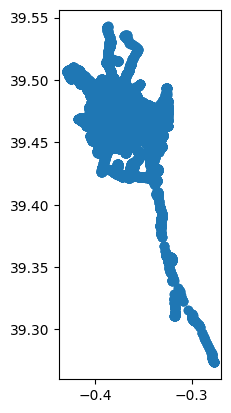

In [56]:
all_nodes = gpd.GeoDataFrame(all_nodes, geometry='geometry')
all_nodes = all_nodes.set_crs('EPSG:4326')
all_nodes.plot()

In [57]:
all_nodes.to_file('data/redes/bus/all_nodes.shp')

# 25-02-2025



In [293]:
links = shapes.copy()

In [294]:
links.shape[0]

29321

In [295]:
# get current and next points in the same row
links['geometry_shifted'] = links.groupby('shape_id')['geometry'].shift(-1)
links['shape_dist_traveled_shifted'] = links.groupby('shape_id')['shape_dist_traveled'].shift(-1)

In [296]:
links['same_point'] = links['geometry'].eq(links['geometry_shifted'])
links['same_point'].sum()

np.int64(2666)

In [297]:
print(links.shape[0])
links = links.loc[links['same_point'].eq(False)]
print(links.shape[0])

29321
26655


## Create nodes from geometry column

In [298]:
nodes = links.drop(columns=['geometry_shifted', 'same_point'])

In [299]:
nodes['node_id'] = nodes.index

In [300]:
nodes = gpd.GeoDataFrame(nodes, geometry='geometry', crs='EPSG:4326')
nodes = nodes.to_crs('EPSG:3035')
nodes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,shape_dist_traveled_shifted,node_id
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (3424986.959 1882786.906),203.0,0
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (3425079.372 1882965.869),442.0,2
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (3425186.141 1883178.173),475.0,4
6,SHP_185_I,39.488139,-0.389662,6,475.0,POINT (3425202.937 1883205.247),494.0,6
7,SHP_185_I,39.488306,-0.389590,7,494.0,POINT (3425211.386 1883222.744),524.0,7
...,...,...,...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (3422929.833 1881464.864),9718.0,29316
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (3422929.131 1881464.906),9718.0,29317
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (3422928.898 1881464.919),9774.0,29318
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0,POINT (3422872.794 1881467.914),9774.0,29319


## Create edges as LineString objects connecting 2 points

In [301]:
print(links.shape[0])
edges = links.dropna(subset=['geometry_shifted'])
print(edges.shape[0])

26655
26561


In [302]:
edges['from_node_id'] = edges.index
edges['to_node_id'] = edges.index + 1

/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_84214/867253860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['from_node_id'] = edges.index
/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_84214/867253860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['to_node_id'] = edges.index + 1


In [303]:
edges['geometry'] = edges.apply(lambda row: LineString([row['geometry'], 
                                                       row['geometry_shifted']]), axis='columns')

/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_84214/2110258855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['geometry'] = edges.apply(lambda row: LineString([row['geometry'],


In [304]:
edges['length'] = edges['shape_dist_traveled_shifted'] - edges['shape_dist_traveled']

/var/folders/1v/srd66w2n4cl1_mmpzwfprky40000gn/T/ipykernel_84214/1626396679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['length'] = edges['shape_dist_traveled_shifted'] - edges['shape_dist_traveled']


In [305]:
edges = edges.drop(columns=['geometry_shifted', 'shape_dist_traveled_shifted', 'same_point'])

In [306]:
edges = gpd.GeoDataFrame(edges, geometry='geometry', crs='EPSG:4326')
edges = edges.to_crs('EPSG:3035')
edges

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,from_node_id,to_node_id,length
0,SHP_185_I,39.484123,-0.391542,0,0.0,"LINESTRING (3424986.959 1882786.906, 3425079.3...",0,1,203.0
2,SHP_185_I,39.485841,-0.390737,2,203.0,"LINESTRING (3425079.372 1882965.869, 3425186.1...",2,3,239.0
4,SHP_185_I,39.487875,-0.389816,4,442.0,"LINESTRING (3425186.141 1883178.173, 3425202.9...",4,5,33.0
6,SHP_185_I,39.488139,-0.389662,6,475.0,"LINESTRING (3425202.937 1883205.247, 3425211.3...",6,7,19.0
7,SHP_185_I,39.488306,-0.389590,7,494.0,"LINESTRING (3425211.386 1883222.744, 3425229.2...",7,8,30.0
...,...,...,...,...,...,...,...,...,...
29315,SHP_1055_V,39.469845,-0.411546,255,9569.0,"LINESTRING (3423078.228 1881457.069, 3422929.8...",29315,29316,148.0
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,"LINESTRING (3422929.833 1881464.864, 3422929.1...",29316,29317,1.0
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,"LINESTRING (3422929.131 1881464.906, 3422928.8...",29317,29318,0.0
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,"LINESTRING (3422928.898 1881464.919, 3422872.7...",29318,29319,56.0


## Save to XML (network.xml)

In [81]:
version = 1
graph_to_load = 'v' + str(version)

In [82]:
root = etree.Element('network', name='emt_network_' + graph_to_load)


## GENERATING NODES

nodes_item = etree.SubElement(root, 'nodes')

for _, node in nodes.iterrows():

    nodes_item.append(etree.Element('node', id=str(node['node_id']), x=str(node['geometry'].coords.xy[0][0]), y=str(node['geometry'].coords.xy[1][0])))


## GENERATING LINKS

links_item = etree.SubElement(root, 'links')

for _, link in edges.iterrows():

    from_node = link['from_node_id']
    to_node = link['to_node_id']
    
    link_item = etree.SubElement(links_item, 'link')

    link_item.set('id', str(_))
    link_item.set('from', str(from_node))
    link_item.set('to', str(to_node))
    link_item.set('length', str(np.round(link['length'], 3)))
    
    # link_item.set('capacity', str(link['capacity']))
    # link_item.set('freespeed', str(link['speed_mps']))
    # link_item.set('permlanes', str(link['NUMLANES']))
    # link_item.set('permlanes', str(1))

    link_item.set('modes', 'bus')

doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

with open('networks/network_' + graph_to_load + '.xml', 'wb') as file:
    file.write(final_xml)

## Map stops to edges

+ get `trip_id` (1) to `stop_id` (N) mapping -- `trips_to_stops`
+ get `shape_id` (1) to `stop_id` (N) mapping -- `shapes_to_stops`
+ get `stop_id` (1) to (`shape_id`, `shape_pt_sequence`) (1) mapping -- `shape_segments_to_stops`

In [194]:
trips_to_stops = stop_times.groupby('trip_id')['stop_id'].apply(pd.Series.to_list)
trips_to_stops.head()

trip_id
1007D0I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
1007D0V    [1282, 1114, 112, 113, 114, 154, 155, 158, 160...
1007D1I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
1007D1V    [1282, 1114, 112, 113, 114, 154, 155, 158, 160...
1007D2I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
Name: stop_id, dtype: object

In [109]:
trips_merged = pd.merge(trips, trips_to_stops, on='trip_id', how='left')
# trips_merged['stop_id'] = trips_merged['stop_id'].apply(lambda x: '_'.join([str(stop) for stop in x]))
trips_merged

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,stop_id
0,23,FES,1033D2V0,Porta de la Mar,0,10332,SHP_1033_V,"[585, 907, 1771, 1772, 912, 910, 664, 665, 128..."
1,23,FES,1033D2V1,Forn d'Alcedo,0,10332,SHP_1033_I,"[2251, 777, 1427, 1428, 1664, 1765, 2041, 2042..."
2,23,FES,1033D2V2,Porta de la Mar,0,10332,SHP_1033_V,"[585, 907, 1771, 1772, 912, 910, 664, 665, 128..."
3,23,FES,1033D2V3,Forn d'Alcedo,0,10332,SHP_1033_I,"[2251, 777, 1427, 1428, 1664, 1765, 2041, 2042..."
4,23,FES,1033D2V4,Porta de la Mar,0,10332,SHP_1033_V,"[585, 907, 1771, 1772, 912, 910, 664, 665, 128..."
...,...,...,...,...,...,...,...,...
2365,93,FES,994D2V,Av. del Cid,0,9942,SHP_994_V,"[2271, 1551, 1918, 1900, 1361, 1490, 1901, 190..."
2366,93,LAB,994D0I,Passeig Maritim,0,9940,SHP_994_I,"[488, 495, 496, 700, 506, 507, 508, 1254, 760,..."
2367,93,LAB,994D0V,Av. del Cid,0,9940,SHP_994_V,"[2271, 1551, 1918, 1900, 1361, 1490, 1901, 190..."
2368,93,SAB,994D1I,Passeig Maritim,0,9941,SHP_994_I,"[488, 495, 496, 700, 506, 507, 508, 1254, 760,..."


In [195]:
shapes_to_stops = trips_merged.groupby('shape_id')['stop_id'].first()
shapes_to_stops.head()

shape_id
SHP_1007_I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
SHP_1007_V    [1282, 1114, 112, 113, 114, 154, 155, 158, 160...
SHP_1017_I    [2403, 2281, 2250, 2206, 1615, 1616, 1617, 161...
SHP_1017_V    [1585, 1981, 70, 1919, 1306, 1590, 1591, 1592,...
SHP_1018_I    [2277, 1520, 1766, 792, 793, 795, 796, 1305, 1...
Name: stop_id, dtype: object

In [179]:
shape_segments_to_stops = gpd.GeoDataFrame()

for shape_id, stops_array in shapes_to_stops.items():
    print(shape_id)
    
    # get only the relevant shape's segments
    shape_segments = edges.loc[edges['shape_id'].eq(shape_id), :]
    
    # get only the relevant shape's stops
    stops_filtered = stops.loc[stops['stop_id'].isin(stops_array), :]
    
    cross = pd.merge(shape_segments, stops_filtered, how='cross', suffixes=['_shape', '_stop'])
    
    # calculating distance from every stop to every shape segment
    cross['distance'] = cross['geometry_stop'].distance(cross['geometry_shape'])
    
    # leave only nearest segment for each stop
    shape_segments_to_stops = pd.concat([shape_segments_to_stops, 
                                         cross.sort_values(by='distance').groupby('stop_id').first()], axis='index')
    

SHP_1007_I
SHP_1007_V
SHP_1017_I
SHP_1017_V
SHP_1018_I
SHP_1018_V
SHP_1019_I
SHP_1019_V
SHP_1020_I
SHP_1020_V
SHP_1021_I
SHP_1021_V
SHP_1022_I
SHP_1022_V
SHP_1026_I
SHP_1026_V
SHP_1027_I
SHP_1027_V
SHP_1029_I
SHP_1029_V
SHP_1030_I
SHP_1030_V
SHP_1031_I
SHP_1031_V
SHP_1033_I
SHP_1033_V
SHP_1034_I
SHP_1034_V
SHP_1041_I
SHP_1041_V
SHP_1045_I
SHP_1045_V
SHP_1046_I
SHP_1046_V
SHP_1047_I
SHP_1047_V
SHP_1050_I
SHP_1050_V
SHP_1051_I
SHP_1051_V
SHP_1052_I
SHP_1052_V
SHP_1053_I
SHP_1053_V
SHP_1054_I
SHP_1054_V
SHP_1055_I
SHP_1055_V
SHP_185_I
SHP_185_V
SHP_651_I
SHP_651_V
SHP_827_I
SHP_827_V
SHP_860_I
SHP_860_V
SHP_873_I
SHP_873_V
SHP_922_I
SHP_922_V
SHP_923_I
SHP_923_V
SHP_930_I
SHP_930_V
SHP_935_I
SHP_935_V
SHP_962_I
SHP_962_V
SHP_963_I
SHP_963_V
SHP_964_I
SHP_964_V
SHP_966_I
SHP_966_V
SHP_967_I
SHP_967_V
SHP_968_I
SHP_968_V
SHP_970_I
SHP_970_V
SHP_982_I
SHP_982_V
SHP_983_I
SHP_983_V
SHP_993_I
SHP_993_V
SHP_994_I
SHP_994_V
SHP_995_I
SHP_995_V
SHP_996_I
SHP_996_V
SHP_997_I
SHP_997_V


In [192]:
shape_segments_to_stops = shape_segments_to_stops.reset_index().loc[:, ['stop_id', 'shape_id', 'shape_pt_sequence']].sort_values(by=['shape_id', 'shape_pt_sequence'])
shape_segments_to_stops

,stop_id,shape_id,shape_pt_sequence
22,1366,SHP_1007_I,0
23,2004,SHP_1007_I,16
24,2005,SHP_1007_I,30
25,2006,SHP_1007_I,39
26,2007,SHP_1007_I,45
...,...,...,...
2332,1848,SHP_997_V,247
2333,1849,SHP_997_V,250
2334,1850,SHP_997_V,254
2340,2389,SHP_997_V,260


In [286]:
# edges.loc[edges['shape_id'].eq(edges['shape_id'].sample(1).iloc[0]), :].to_file('edges_sample.shp', driver='ESRI Shapefile')

In [329]:
trips.groupby('route_id')['shape_id'].nunique().max()

np.int64(4)

## To XML (transitSchedule.xml)

In [333]:
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry
0,10,10,Doctor Lluch - Mediterrània,C DOCTOR LLUCH 99 (DAVANT) - VALÈNCIA,39.467234,-0.328306,NaN,NaN,0,NaN,POINT (3430171.588 1880191.51)
1,1007,1007,Jesús Morante Borrás (I),AV JESUS MORANTE BORRAS 26 - VALÈNCIA,39.451015,-0.345435,NaN,NaN,0,NaN,POINT (3428483.307 1878613.505)
2,1008,1008,Jesús Morante Borrás (II),AV JESUS MORANTE BORRAS 54 - VALÈNCIA,39.449483,-0.344468,NaN,NaN,0,NaN,POINT (3428545.216 1878434.112)
3,1009,1009,Jesús Morante Borrás (III),AV JESUS MORANTE BORRAS 86 - VALÈNCIA,39.447905,-0.344029,NaN,NaN,0,NaN,POINT (3428561.35 1878255.962)
4,1010,1010,Jesús Morante Borrás (IV),AV JESUS MORANTE BORRAS 158 - VALÈNCIA,39.444148,-0.343987,NaN,NaN,0,NaN,POINT (3428513.669 1877843.33)
...,...,...,...,...,...,...,...,...,...,...,...
1141,978,978,Carters (parell) - Primer de Maig,C CARTEROS 84 - VALÈNCIA,39.448198,-0.389623,NaN,NaN,0,NaN,POINT (3424659.198 1878824.318)
1142,979,979,Carters - Mossén Febrer,C CARTEROS 60 (DAVANT) - VALÈNCIA,39.450171,-0.388974,NaN,NaN,0,NaN,POINT (3424741.82 1879033.107)
1143,983,983,Ramón y Cajal - Bailén,GV RAMON Y CAJAL 1 - VALÈNCIA,39.463089,-0.379623,NaN,NaN,0,NaN,POINT (3425719.575 1880339.622)
1144,985,985,Centre de Salut Benimaclet,C JAIME ESTEVE CUBELLS 6 - VALÈNCIA,39.483322,-0.358504,NaN,NaN,0,NaN,POINT (3427804.822 1882310.329)


In [315]:
vehicle_counter = 0

In [317]:
root = etree.Element('transitSchedule', name='emt')


transit_stops_item = etree.SubElement(root, 'transitStops')

# STOP FACILITIES
for _, stop in stops.iterrows():

    transit_stops_item.append(etree.Element('stopFacility', 
                                            id=str(stop['stop_id']), 
                                            x=str(stop['geometry'].coords.xy[0][0]), 
                                            y=str(stop['geometry'].coords.xy[1][0]),
                                            linkRefId=""))
    
# transit_line_item = etree.SubElement(root, 'transitLine')

# TRANSIT LINES
for _, route in routes.iterrows():
    
    transit_line_item = etree.SubElement(root, 'transitLine', 
                                          id=str(route['route_id']),
                                          name=str(route['route_short_name']))
    
    # TRANSIT ROUTE
    # filtering trips (transitRoute) for this route (transitLine) only
    trips_filtered = trips.loc[trips['route_id'].eq(route['route_id']),:]
    
    for _, trip in trips_filtered.iterrows():
        
        transit_route_item = etree.SubElement(transit_line_item, 'transitRoute', 
                                              id=str(trip['trip_id']))
        
        # TRANSIT MODE
        transit_mode_item = etree.SubElement(transit_route_item, 'transitMode')
        transit_mode_item.text = "bus"
    
        routes_profile_item = etree.SubElement(transit_route_item, 'routeProfile')
        
        # ROUTE PROFILE
        # filtering stop_times for the current trip only
        stop_times_filtered = stop_times_merged.loc[stop_times_merged['trip_id'].eq(trip['trip_id']),:]
        
        is_first_stop = True
        last_stop_index = stop_times_filtered.tail(1).index
        for _, stop_time in stop_times_filtered.iterrows():
            if is_first_stop:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=str(stop_time['stop_id']),
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     # arrivalOffset=str(stop_time['arrival_time_offset_str'])
                                                         ))
                is_first_stop = False
            elif _ == last_stop_index:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=str(stop_time['stop_id']),
                                                     # departureOffset=str(stop_time['departure_time_offset_str']),
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str'])
                                                         ))
            else:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=str(stop_time['stop_id']),
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     departureOffset=str(stop_time['departure_time_offset_str'])
                                                         ))

        # ROUTE (all the links for a specific routes, not only the ones with stops)
        route_item = etree.SubElement(transit_route_item, 'route')
        
        edges_filtered = edges.loc[edges['shape_id'].eq(trip['shape_id']), :]
        
        for _, edge in edges_filtered.iterrows():
            route_item.append(etree.Element('link', 
                                            refId=str(_)))
        
        # DEPARTURES
        departures_item = etree.SubElement(transit_route_item, 'departures')
        
        # if there is a frequency for a trip, ...
        if trip['trip_id'] in frequencies['trip_id'].values:
            # print(f'Trip {trip['trip_id']} has a frequency')
            # ...generate a departure for every frequency
            
            # filtering frequencies for the current trip only
            frequencies_filtered = frequencies.loc[frequencies['trip_id'].eq(trip['trip_id']),:]
            
            for _, frequency in frequencies_filtered.iterrows(): # in every frequency there is an interval with it's frequency in seconds 
                departures = pd.timedelta_range(start=frequency['start_time'], 
                                                end=frequency['end_time'], 
                                                freq=str(frequency['headway_secs']) + 's', 
                                                closed='left')
                
                for departure_index, departure in enumerate(departures):
                    vehicle_counter = vehicle_counter + 1
                    departures_item.append(etree.Element('departure', 
                                                         id=str(_) + '_' + str(departure_index),
                                                         departureTime=timedelta_to_str(departure),
                                                         vehicleRefId='veh_' + str(vehicle_counter)))
        # if there is no frequency for a trip, ...
        else:
            vehicle_counter = vehicle_counter + 1
            
            # ...generate only one departure from stop_times_departures
            single_departure = stop_times_filtered.loc[stop_times_filtered['trip_id'].eq(trip['trip_id']),'departure_time_absolute'].iloc[0]
            departures_item.append(etree.Element('departure', 
                                                     id=str(_),
                                                     departureTime=timedelta_to_str(single_departure),
                                                     vehicleRefId='veh_' + str(vehicle_counter)))


doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

if not os.path.exists('networks'):
    os.mkdir('networks')
    
with open('networks/transitSchedule.xml', 'wb') as file:
    file.write(final_xml)

## To XML (transitVehicles.xml)

In [330]:
from lxml import etree

# Namespace and schema locations
namespace = "http://www.matsim.org/files/dtd"
schema_location = "http://www.matsim.org/files/dtd/vehicleDefinitions_v1.0.xsd"

# Namespace map
nsmap = {
    None: namespace,  # Default namespace
    "xsi": "http://www.w3.org/2001/XMLSchema-instance"
}

# Root element with namespaces
root = etree.Element("vehicleDefinitions", nsmap=nsmap)
root.set(etree.QName(nsmap["xsi"], "schemaLocation"), f"{namespace} {schema_location}")

# Vehicle type definition
vehicle_type = etree.SubElement(root, "vehicleType", id="bus")

description = etree.SubElement(vehicle_type, "description")
description.text = "Ordinary Bus"

capacity = etree.SubElement(vehicle_type, "capacity")
seats = etree.SubElement(capacity, "seats", persons="50")
standing = etree.SubElement(capacity, "standingRoom", persons="30")

length = etree.SubElement(vehicle_type, "length", meter="25.0")

# Adding vehicles
for vehicle_id in range(1, vehicle_counter + 1):
    etree.SubElement(root, "vehicle", id='vehicle_' + str(vehicle_id), type='bus')

# Convert to pretty-printed XML string
xml_str = etree.tostring(root, pretty_print=True, xml_declaration=True, encoding='UTF-8')

# Save to file or print
with open("networks/vehicleDefinitions.xml", "wb") as f:
    f.write(xml_str)

# Date check for calendar.txt and calendar_dates.txt

In [348]:
calendar.dtypes

service_id            object
monday                 int64
tuesday                int64
wednesday              int64
thursday               int64
friday                 int64
saturday               int64
sunday                 int64
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [392]:
weekday_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
date_to_check = pd.to_datetime('2024-01-01')

condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)

candidate_service_ids = calendar.loc[condition_date_range & condition_weekday]
candidate_service_ids


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,LAB,1,1,1,1,1,0,0,2024-01-01,2026-12-31
3,NLAB,1,1,1,0,0,0,1,2024-01-01,2026-12-31
5,L38-755,1,1,1,1,1,1,1,2024-01-01,2026-12-31
6,L38-810,1,1,1,1,1,1,1,2024-01-01,2026-12-31


In [393]:
if candidate_service_ids.shape[0] > 0:
    if date_to_check in calendar_dates['date'].values:
        service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
        service_ids_to_delete = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(2), 'service_id']
        
        
        # adding service ids
        candidate_service_ids = pd.concat([candidate_service_ids, 
                                           calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_add), :]], axis='index')
        print(f'Added: {service_ids_to_add}')
        
        # removing service ids
        candidate_service_ids_merged = pd.merge(candidate_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_delete), :], how='left', indicator=True)
        candidate_service_ids = candidate_service_ids_merged.loc[candidate_service_ids_merged['_merge'].ne('both')].drop(columns='_merge')
        print(f'Deleted: {service_ids_to_delete}')
    else:
        print('No changes were made to the candidate list.')
else:
    if date_to_check in calendar_dates['date'].values:
        if calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), :].shape[0] > 0:
            pass # add exception
    else:
        print('No service_id found for this date.')

Added: 31    FES
Name: service_id, dtype: object
Deleted: 30    LAB
Name: service_id, dtype: object


In [394]:
candidate_service_ids

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
1,NLAB,1,1,1,0,0,0,1,2024-01-01,2026-12-31
2,L38-755,1,1,1,1,1,1,1,2024-01-01,2026-12-31
3,L38-810,1,1,1,1,1,1,1,2024-01-01,2026-12-31
4,FES,0,0,0,0,0,0,1,2024-01-01,2026-12-31


In [362]:
df1 = candidate_service_ids.copy()
df2 = candidate_service_ids.loc[candidate_service_ids['service_id'].isin(['NLAB', 'LAB'])]

In [367]:
df_merged = pd.merge(df1, df2, how='left', indicator=True)
df_merged.loc[df_merged['_merge'].ne('both')]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,_merge
2,L38-755,1,1,1,1,1,1,1,2024-01-01,2026-12-31,left_only
3,L38-810,1,1,1,1,1,1,1,2024-01-01,2026-12-31,left_only
